### Problem 1

Imports

In [1]:
from pathlib import Path
from datetime import datetime
import pandas as pd
from skimage.io import imread, imsave
import cv2
import numpy as np
import matplotlib.pyplot as plt
import natsort
from skimage.util import montage
from skimage import exposure
import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


Settings

In [2]:
# path to the images folder
image_folder = "/Users/teresaglauner/Documents/Hamburg_folder/CRC_TMA/image_data"
# dictionary with the images to select and their colours (as float rgb values)
images = {"PanCK": [0, 1, 1], "CD45": [1, 0, 1], "Vimentin": [1, 1, 0]}
# image width of the collage image
collage_width = 30
# downscale images to x percent of the original
# input 100 if images should not be touched
images_rescale_percentage = 20
# gamma correction values
gamma = 0.8
gain = 1


Folder processing

In [3]:
composites = []
for recording in natsort.natsorted(Path(image_folder).iterdir()):
    composite = []
    if recording.is_dir() and recording.name != ".DS_Store":
        for image in recording.joinpath("rescaled").iterdir():
            if image.is_file() and image.stem in images.keys():
                # read image
                im = imread(image, as_gray=True)
                # downscale image if necessary
                if images_rescale_percentage < 100:
                    im = cv2.resize(
                        im,
                        (0, 0),
                        fx=images_rescale_percentage / 100,
                        fy=images_rescale_percentage / 100,
                        interpolation=cv2.INTER_AREA,
                    )
                # normalise image
                im = (im - np.min(im)) / (np.max(im) - np.min(im))
                # adjust image gamma
                im = exposure.adjust_gamma(im, gamma, gain)
                # create 3d array from 2d image
                i3d = np.atleast_3d(im)
                # colourize image
                ic = i3d * images[image.stem]
                # add to composite array
                composite.append(ic)
        # merging images
        im = np.sum(composite, axis=0)
        # normalise image again and adjust range
        im = (im - np.min(im)) / (np.max(im) - np.min(im)) * 255
        # add to list of all images
        composites.append(im)
composites = np.array(composites, dtype=np.uint8)


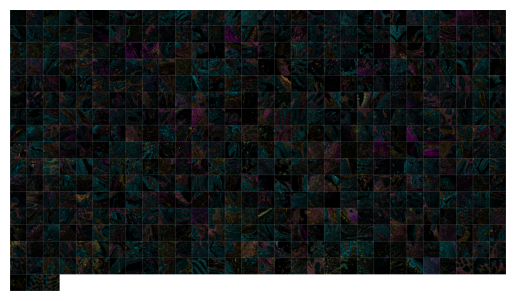

In [18]:
# Calculate height and width of the collage
height = np.ceil(len(composites) / collage_width)
width = collage_width
# Create collage without acis
collage = montage(
    composites,
    grid_shape=(height, width),
    channel_axis=3,
    padding_width=1,
    fill=[255, 255, 255, 255],
)
plt.axis("off")
# Save collage to folder
imsave(Path(image_folder).parent.joinpath("collage.png"), collage)
plt.imshow(collage)


### Problem 2

Settings

In [15]:
# path to the images folder
image_folder = "/Users/teresaglauner/Documents/Hamburg_folder/CRC_TMA/image_data"
# path to the excel file
excel_file = "/Users/teresaglauner/Documents/Hamburg_folder/CRC_TMA/summary_clinical_data_modified.xlsx"
# column with target names
column_target_names = "TMA Localisation"
# column with group names
column_group_names = "pT group"
# target to inspect
targets = ['ARG1', 'ASCT2', 'ATP5A', 'CA9', 'CD14','CD163', 'STING1',
       'CD20', 'CD3e', 'CD31', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8',
       'CD98', 'CPT1A', 'CS', 'DCN', 'GS', 'MPO', 'MSH2', 'MSH6',
       'CytC', 'FoxP3', 'GLS', 'GLUT1', 'HLADRa', 'Ki67',
       'LDH', 'MCT1', 'PDL1', 'PD1', 'PKM2', 'PanCK', 'SMA', 'Vimentin']


Folder processing

In [16]:
comparison = []
# parse images
for recording in natsort.natsorted(Path(image_folder).iterdir()):
    if recording.is_dir() and recording.name != ".DS_Store":
        for image in recording.joinpath("rescaled").iterdir():
            if image.stem in targets:
                # read image
                im = imread(image, as_gray=True)
                comparison.append(
                    [
                        recording.name,
                        image.stem,
                        im.mean(),
                        np.median(im),
                        im.min(),
                        im.max(),
                        im.std(),
                    ]
                )

# create dataframes
df1 = pd.DataFrame(
    comparison, columns=["recording", "target", "mean", "median", "min", "max", "SD"]
)
df2 = pd.read_excel(excel_file)

# add grouping information from excel file
grouping = pd.Series(
    df2[column_group_names].values,
    index=[x.replace(" ", "") for x in df2[column_target_names]],
).to_dict()
df1["group"] = df1["recording"].map(grouping)

# group and save to excel file
df1_groups = (
    df1[df1["target"].isin(targets)]
    .groupby(["target", "group"])
    .mean(numeric_only=True)
)
df1_groups.to_excel(
    Path(image_folder).parent.joinpath(
        f"{datetime.now().strftime('%d%m%y%H%M%S')}_comparison.xlsx"
    )
)
df1.to_excel(
    Path(image_folder).parent.joinpath(
        f"{datetime.now().strftime('%d%m%y%H%M%S')}_patients.xlsx"
    )
)